In [10]:
# allows to import own functions
import sys
import os
import re
root_project = re.findall(r'(^\S*TFM-master)', os.getcwd())[0]
sys.path.append(root_project)

from src.utils.help_func import results_searchcv, make_train_val_test,\
    plot_predictions, errors_distribution, plot_visualizations
from src.features.add_features import feature_graph, feature_pop,\
    feature_total_dep
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from scipy.stats import randint
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from yellowbrick.regressor import ResidualsPlot
import joblib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import time

In [11]:
df_i = pd.read_pickle(
    f"{root_project}/data/processed/features_model_rev17.pickle")
df_i

,i_country,R0,Tc,Tr,omega,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,mort_pow_3,...,degree,closeness,country_pop,country_departures,exposed_pop,inf_pow_1_log,inf_pow_2_log,mort_pow_1_log,mort_pow_2_log,mort_pow_3_log
0,NIC,15.127089,1.432646,21.671765,0.810188,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.045045,0.386760,6465513.0,2668,3.600123e+08,-36.043653,-36.043653,-36.043653,-36.043653,-36.043653
1,MAC,11.712490,1.513652,17.728633,0.300084,23.071429,49.500000,0.445820,0.727273,3.891892,...,0.081081,0.378194,631636.0,4326,1.879682e+09,3.138595,3.901973,-0.807839,-0.318454,1.358895
2,ZWE,11.196699,0.973025,10.894668,0.201303,1162.785714,2241.777778,0.195651,0.157861,1.262386,...,0.072072,0.405109,14439018.0,8183,3.124648e+08,7.058574,7.715024,-1.631424,-1.846041,0.233004
3,GNQ,2.841725,8.012827,22.770250,0.930842,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.063063,0.391534,1308974.0,7220,4.266727e+08,-36.043653,-36.043653,-36.043653,-36.043653,-36.043653
4,SAU,15.554773,1.814752,28.228049,0.468460,1.214286,1.000000,0.823529,7.000000,7.000000,...,0.387387,0.526066,33699947.0,59907,5.227182e+09,0.194156,0.000000,-0.194156,1.945910,1.945910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245203,VCT,11.313111,0.334244,3.781340,0.861811,29767.714286,42360.000000,0.431191,0.530270,1.736062,...,0.040541,0.312236,110210.0,824,1.969842e+06,10.301180,10.653960,-0.841204,-0.634368,0.551619
245204,MDG,12.405010,1.298577,16.108865,0.473386,9.357143,26.000000,0.603053,1.519231,5.642857,...,0.072072,0.425287,26262368.0,107,2.476860e+08,2.236140,3.258097,-0.505749,0.418204,1.730391
245205,YEM,5.530336,2.310517,12.777933,0.129257,20.285714,16.818182,0.285211,0.437838,1.246154,...,0.144144,0.414953,28498687.0,1051,1.823585e+09,3.009917,2.822461,-1.254525,-0.825907,0.220062
245206,BFA,6.799404,4.281189,29.109535,0.240079,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.121622,0.411874,19751535.0,755,4.913618e+08,-36.043653,-36.043653,-36.043653,-36.043653,-36.043653


In [12]:
df = df_i.sample(200000, random_state=42)
df.reset_index(inplace=True)
df

,index,i_country,R0,Tc,Tr,omega,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,...,degree,closeness,country_pop,country_departures,exposed_pop,inf_pow_1_log,inf_pow_2_log,mort_pow_1_log,mort_pow_2_log,mort_pow_3_log
0,149349,TCA,6.501499,3.433347,22.321902,0.247644,0.000000,0.000000,0.000000,0.000000,...,0.063063,0.392226,38191.0,3006,3.924923e+08,-36.043653,-36.043653,-36.043653,-36.043653,-36.043653
1,1109,ABW,14.386538,1.752934,25.218656,0.996120,1.214286,-1.000000,2.000000,-8.500000,...,0.072072,0.415730,105845.0,2592,4.753562e+08,0.194156,NaN,0.693147,NaN,-0.817445
2,103251,YEM,7.319971,2.552980,18.687743,0.243042,2.714286,3.000000,0.578947,1.833333,...,0.144144,0.414953,28498687.0,1051,1.823585e+09,0.998529,1.098612,-0.546544,0.606136,1.299283
3,103573,PRI,12.322530,1.895389,23.355990,0.854275,0.000000,0.000000,0.000000,0.000000,...,0.144144,0.436149,3195153.0,2170,5.408732e+08,-36.043653,-36.043653,-36.043653,-36.043653,-36.043653
4,28407,PNG,6.851018,0.814722,5.581676,0.274797,1919.500000,3328.444444,0.223905,0.200861,...,0.072072,0.370618,8606316.0,253,5.404628e+08,7.559820,8.110260,-1.496533,-1.605141,-0.145591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,57278,CIV,9.018405,0.713281,6.432656,0.188582,20036.714286,25399.058824,0.134974,0.087687,...,0.166667,0.419660,25069229.0,3508,6.538634e+08,9.905322,10.142467,-2.002676,-2.433977,-0.526294
199996,4650,TZA,11.290588,1.197501,13.520495,0.814214,0.000000,0.000000,0.000000,0.000000,...,0.148649,0.427746,56318348.0,405,6.344773e+08,-36.043653,-36.043653,-36.043653,-36.043653,-36.043653
199997,122911,TUR,11.240084,0.787031,8.846295,0.804205,23.142857,125.000000,0.626543,1.624000,...,0.833333,0.606557,82319724.0,22968,5.989523e+09,3.141686,4.828314,-0.467538,0.484892,1.624327
199998,224220,STP,2.391622,3.712377,8.878602,0.589320,0.000000,0.000000,0.000000,0.000000,...,0.027027,0.347418,211028.0,530,4.163529e+07,-36.043653,-36.043653,-36.043653,-36.043653,-36.043653


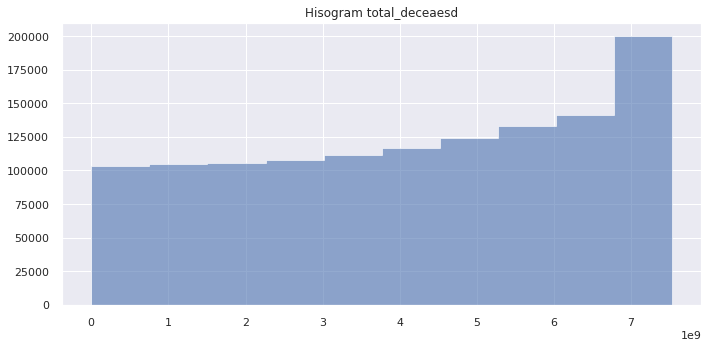

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(df['total_infected'], density=False, histtype='stepfilled', cumulative=True, alpha=0.6)
ax.set(title='Hisogram total_deceaesd')
plt.tight_layout()

/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/statsmodels/nonparametric/kde.py:177: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  probs = [integrate.quad(func, support[i - 1], support[i],


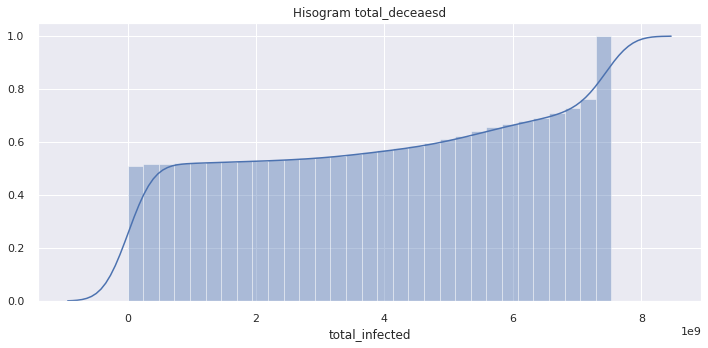

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
kwargs = {'cumulative':True}
sns.distplot(df['total_infected'], hist_kws=kwargs, kde_kws=kwargs)
ax.set(title='Hisogram total_deceaesd')
plt.tight_layout()

/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/statsmodels/nonparametric/kde.py:177: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  probs = [integrate.quad(func, support[i - 1], support[i],


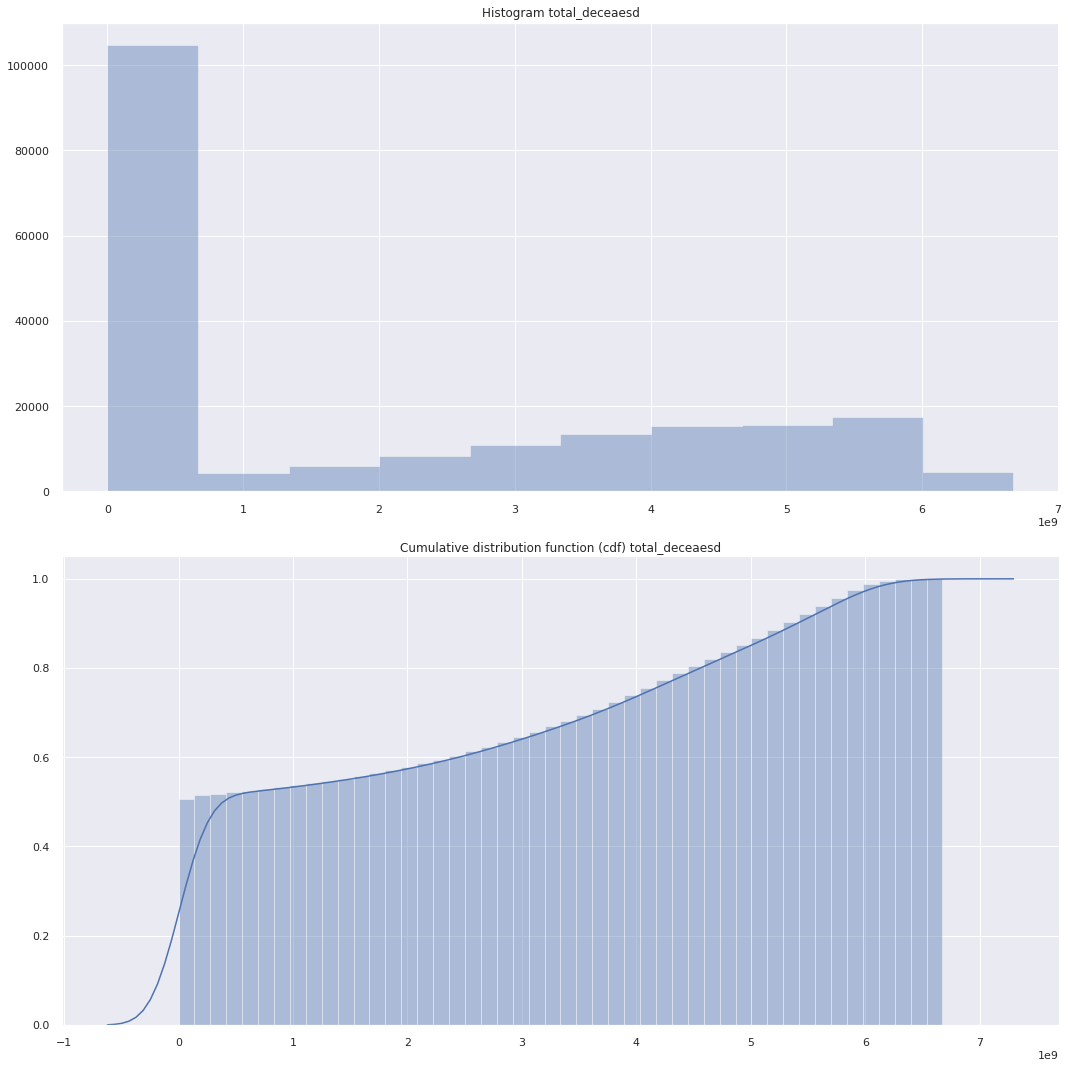

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))
ax[0].hist(df['total_deceased'], density=False, histtype='stepfilled', alpha=0.4)
ax[0].set(title='Histogram total_deceaesd')
plt.tight_layout()

kwargs = {'cumulative':True}
sns.distplot(df['total_deceased'], hist_kws=kwargs, kde_kws=kwargs, ax=ax[1])
ax[1].set(title='Cumulative distribution function (cdf) total_deceaesd',xlabel='')
plt.tight_layout()

<ipython-input-13-c52527c6c0c6>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(10, 5))


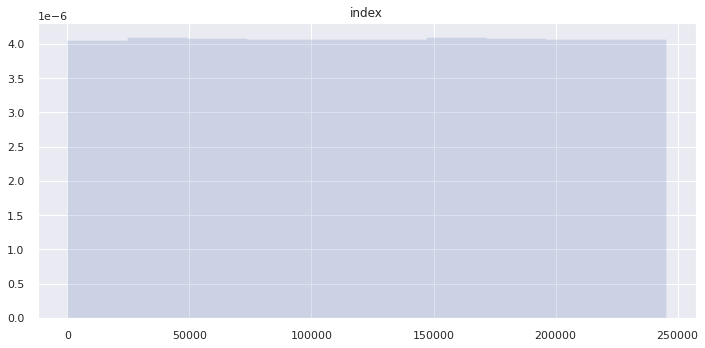

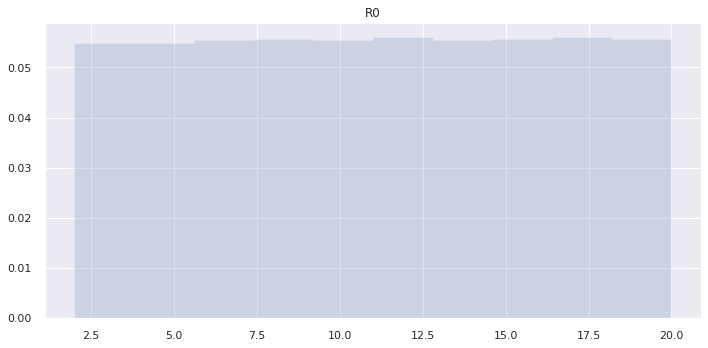

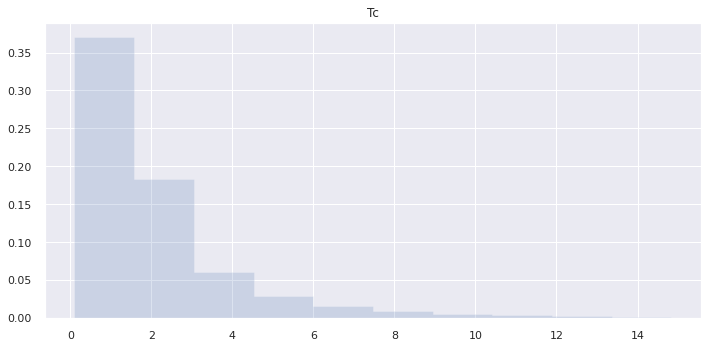

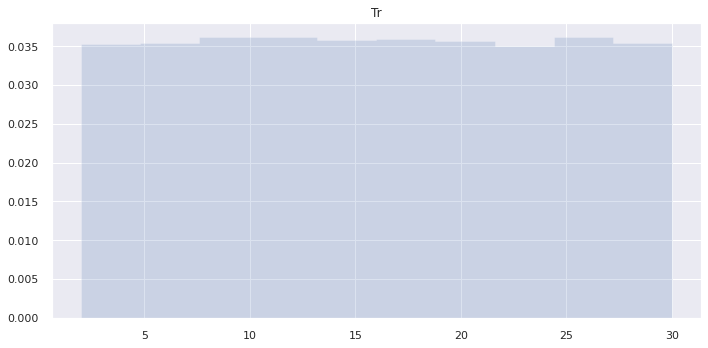

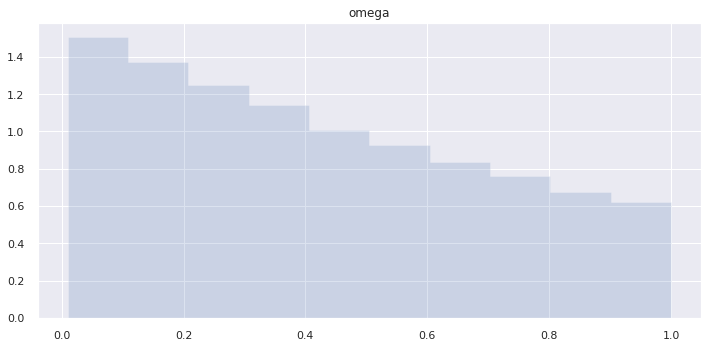

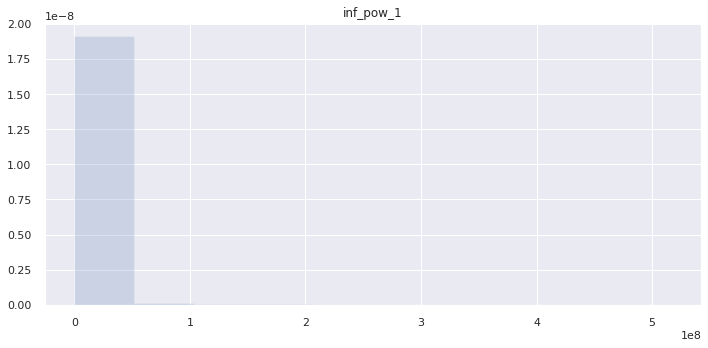

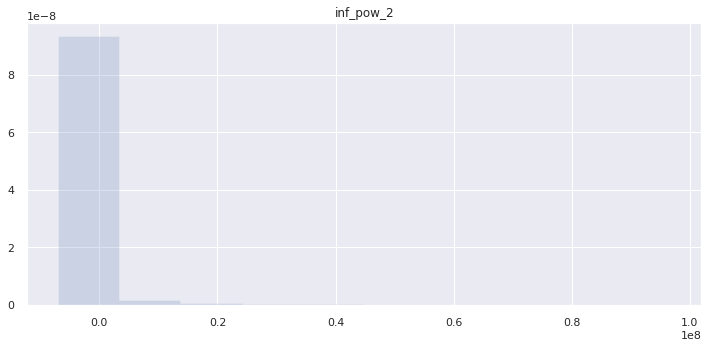

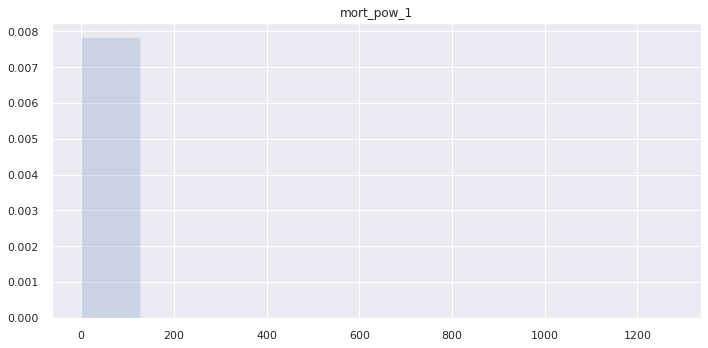

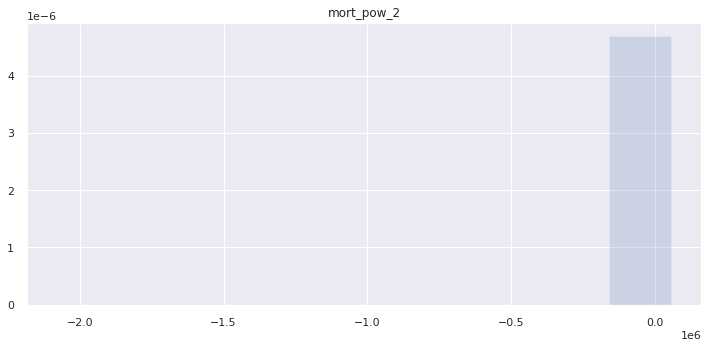

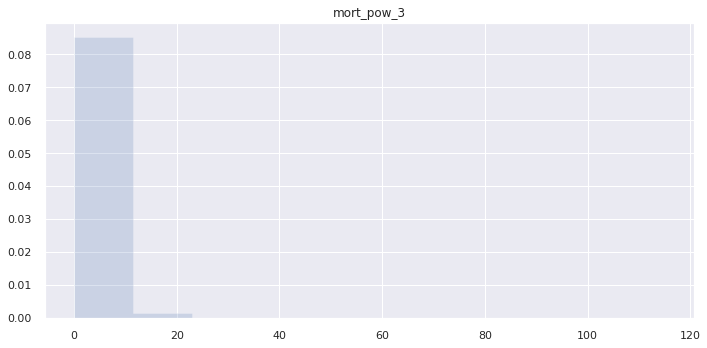

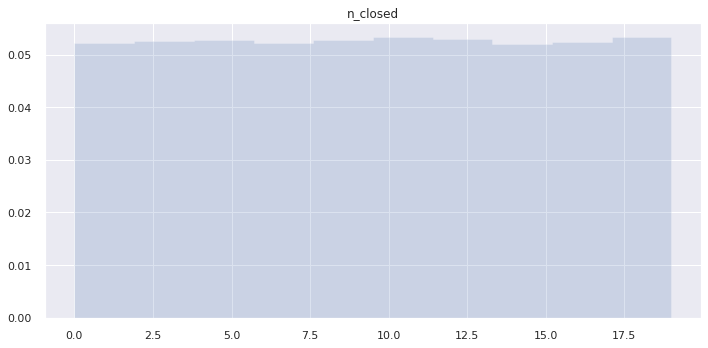

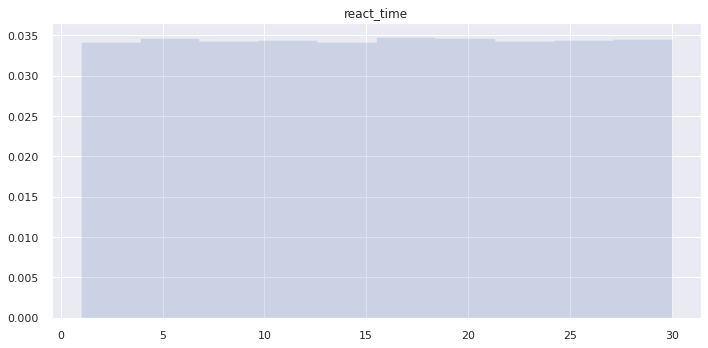

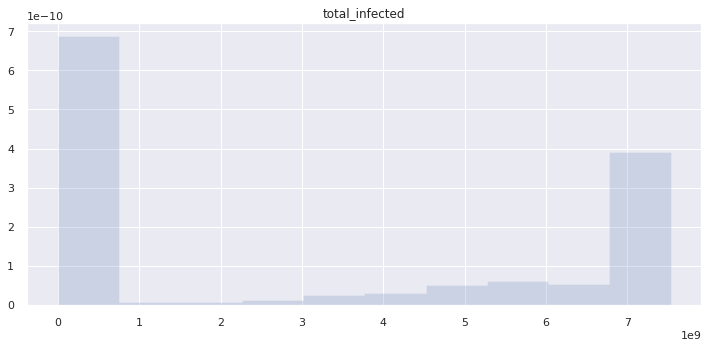

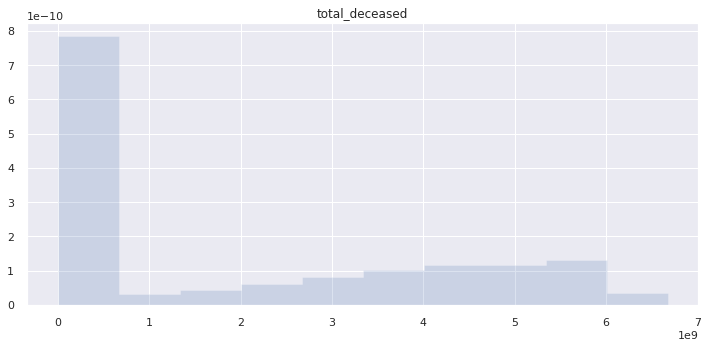

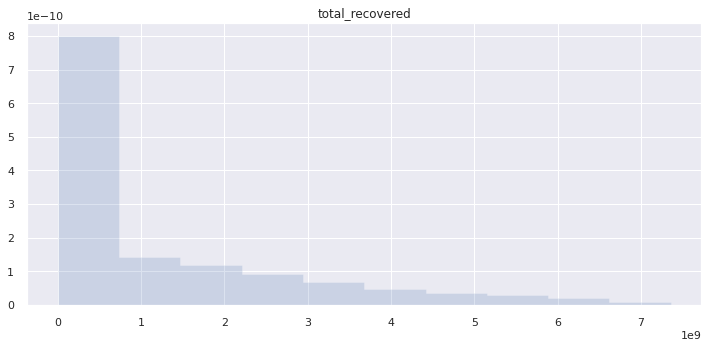

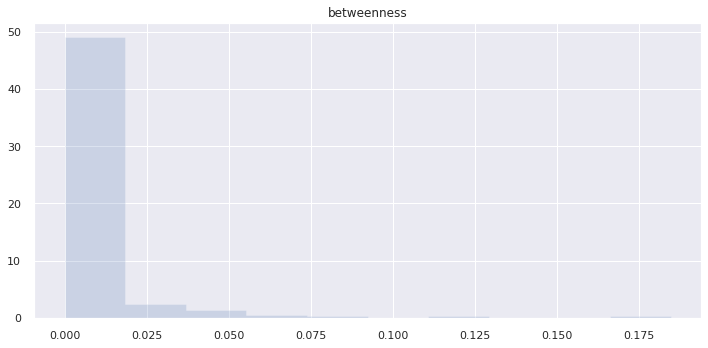

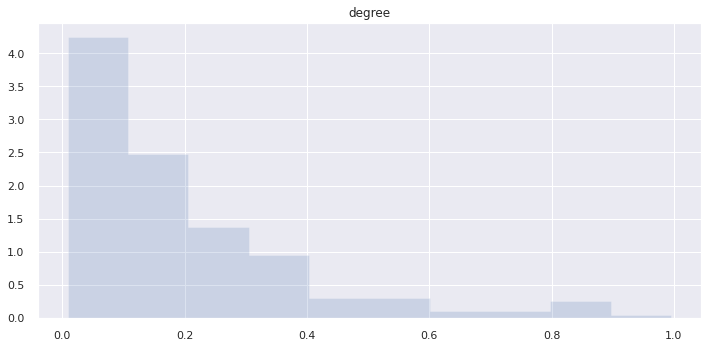

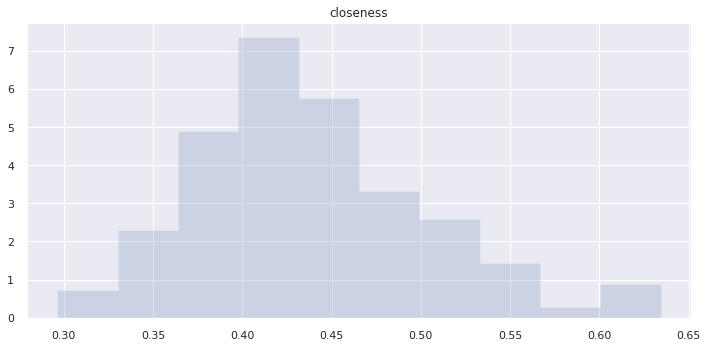

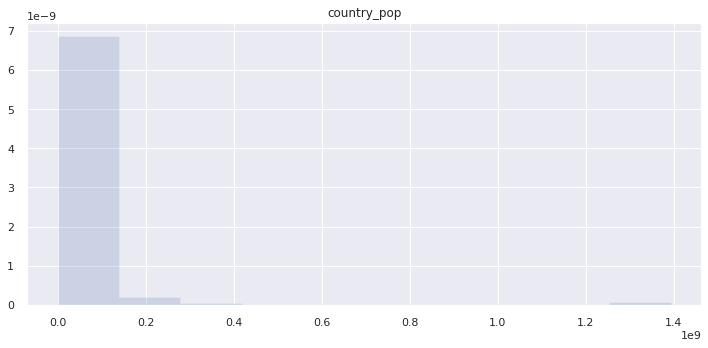

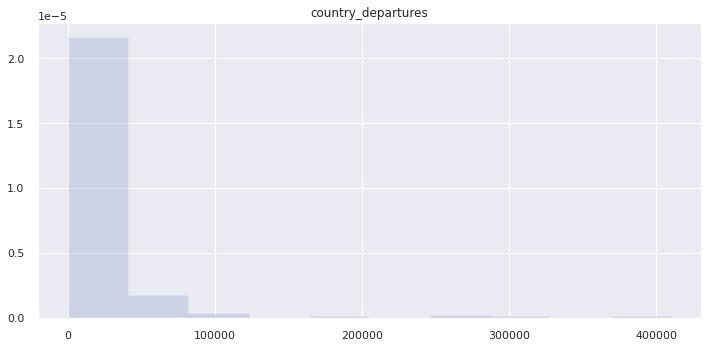

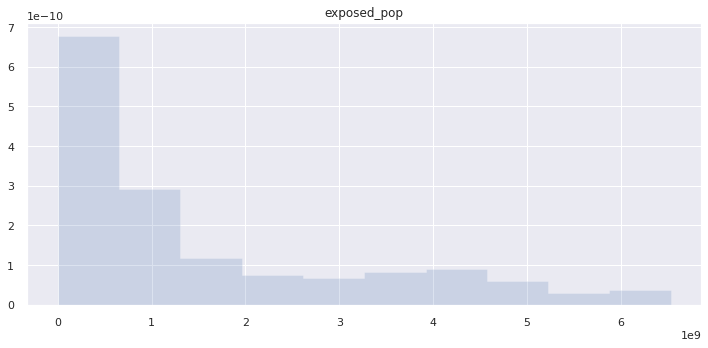

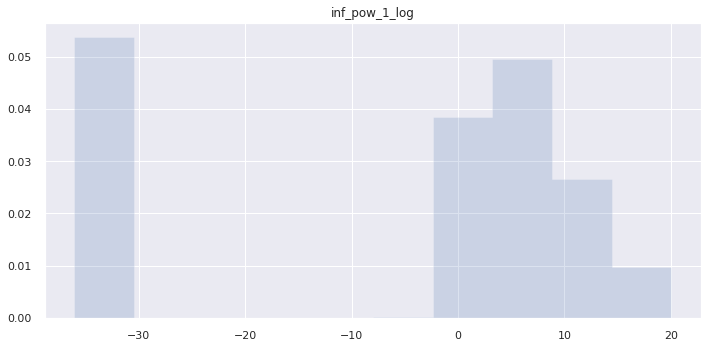

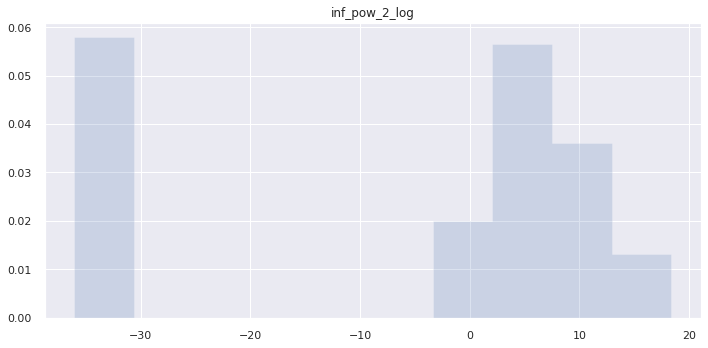

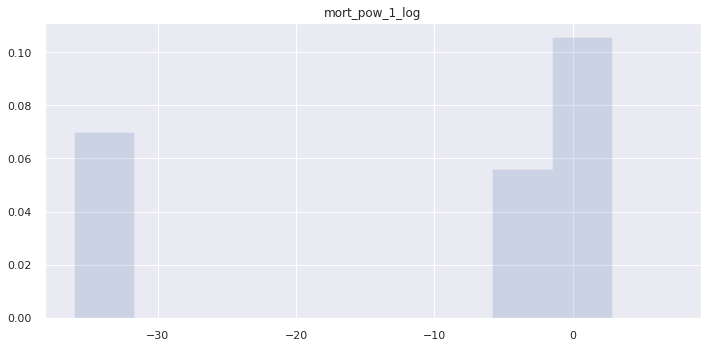

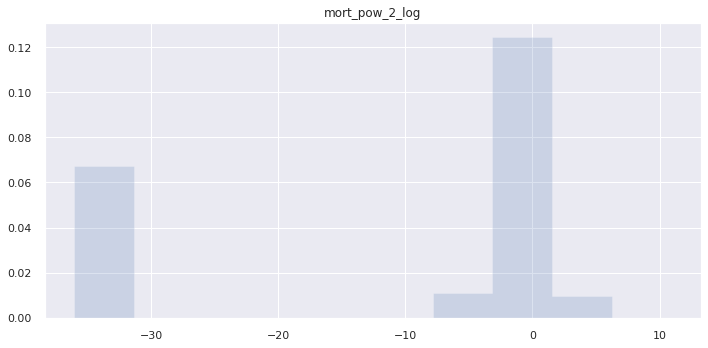

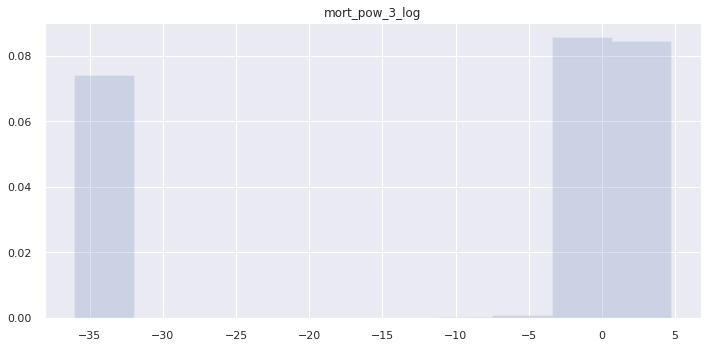

In [13]:
columns = df.describe().columns

for c in columns:
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # df[c].plot(kind='hist', ax=ax, title=str(c))
    ax.hist(df[c], density=True, histtype='stepfilled', alpha=0.2)
    ax.set(title=str(c))
    plt.tight_layout()

In [4]:
features = [
    'R0',
    'Tc',
    'omega',
    'Tr',
    'inf_pow_1',
    'inf_pow_2',
    'mort_pow_1',
    'mort_pow_2',
    'mort_pow_3',
    'n_closed',
    'react_time',
    'total_deceased',
    'betweenness',
    'degree',
    'closeness',
    'country_pop',
    'country_departures',
    'exposed_pop'
    ]

df= df[features]
df

,R0,Tc,omega,Tr,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,mort_pow_3,n_closed,react_time,total_deceased,betweenness,degree,closeness,country_pop,country_departures,exposed_pop
0,6.501499,3.433347,0.247644,22.321902,0.000000,0.000000,0.000000,0.000000,0.000000,18,16,0.000000e+00,0.000068,0.063063,0.392226,38191.0,3006,3.924923e+08
1,14.386538,1.752934,0.996120,25.218656,1.214286,-1.000000,2.000000,-8.500000,0.441558,8,26,3.400000e+01,0.000327,0.072072,0.415730,105845.0,2592,4.753562e+08
2,7.319971,2.552980,0.243042,18.687743,2.714286,3.000000,0.578947,1.833333,3.666667,15,5,1.045727e+07,0.000565,0.144144,0.414953,28498687.0,1051,1.823585e+09
3,12.322530,1.895389,0.854275,23.355990,0.000000,0.000000,0.000000,0.000000,0.000000,10,7,0.000000e+00,0.012937,0.144144,0.436149,3195153.0,2170,5.408732e+08
4,6.851018,0.814722,0.274797,5.581676,1919.500000,3328.444444,0.223905,0.200861,0.864511,13,27,4.297118e+09,0.000579,0.072072,0.370618,8606316.0,253,5.404628e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,9.018405,0.713281,0.188582,6.432656,20036.714286,25399.058824,0.134974,0.087687,0.590791,19,8,3.922632e+09,0.000908,0.166667,0.419660,25069229.0,3508,6.538634e+08
199996,11.290588,1.197501,0.814214,13.520495,0.000000,0.000000,0.000000,0.000000,0.000000,11,27,0.000000e+00,0.005219,0.148649,0.427746,56318348.0,405,6.344773e+08
199997,11.240084,0.787031,0.804205,8.846295,23.142857,125.000000,0.626543,1.624000,5.075000,12,15,4.006847e+07,0.043460,0.833333,0.606557,82319724.0,22968,5.989523e+09
199998,2.391622,3.712377,0.589320,8.878602,0.000000,0.000000,0.000000,0.000000,0.000000,1,14,0.000000e+00,0.000005,0.027027,0.347418,211028.0,530,4.163529e+07


In [5]:
df.describe()

,R0,Tc,omega,Tr,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,mort_pow_3,n_closed,react_time,total_deceased,betweenness,degree,closeness,country_pop,country_departures,exposed_pop
count,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,2.000000e+05,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000,2.000000e+05
mean,11.027758,2.038845,0.424251,16.000081,2.481344e+06,5.131763e+05,0.288794,-2.275613e+01,2.085641,9.517240,15.514320,1.940097e+09,0.006568,0.193380,0.439632,3.680070e+07,19014.162875,1.589259e+09
std,5.188761,1.952338,0.278663,8.064538,2.120217e+07,3.542140e+06,2.920914,6.295388e+03,3.232192,5.765206,8.649929,2.242580e+09,0.018899,0.189147,0.065828,1.400405e+08,46936.561860,1.682201e+09
min,2.000118,0.100827,0.010003,2.000363,0.000000e+00,-7.044363e+06,0.000000,-2.076870e+06,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.009009,0.296395,1.164600e+04,6.000000,2.425670e+05
25%,6.541700,0.816881,0.181653,9.059625,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,5.000000,8.000000,0.000000e+00,0.000058,0.063063,0.392920,1.136191e+06,1408.000000,3.924923e+08
50%,11.044352,1.454237,0.386084,15.981019,1.914286e+01,2.516667e+01,0.186635,1.394419e-01,0.897734,10.000000,16.000000,9.291917e+07,0.000554,0.126126,0.427746,6.982084e+06,4211.000000,7.287879e+08
75%,15.524511,2.476645,0.646630,22.988787,2.037661e+03,2.438977e+03,0.437783,6.449417e-01,2.899359,15.000000,23.000000,4.123972e+09,0.003726,0.252252,0.477419,2.554982e+07,16050.000000,2.532563e+09
max,19.999707,14.836842,0.999996,29.999879,5.167385e+08,9.676703e+07,1274.000000,5.611237e+04,115.000000,19.000000,30.000000,6.673690e+09,0.184702,0.995495,0.634286,1.392730e+09,410193.000000,6.534162e+09


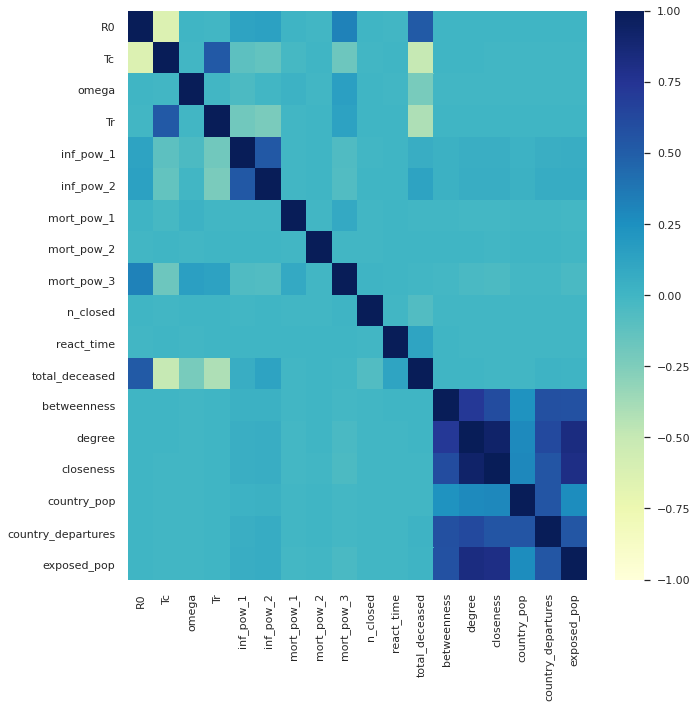

In [8]:
corr_matrix = df.corr()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr_matrix, vmax=1, vmin=-1, cmap="YlGnBu", ax=ax)
plt.tight_layout()

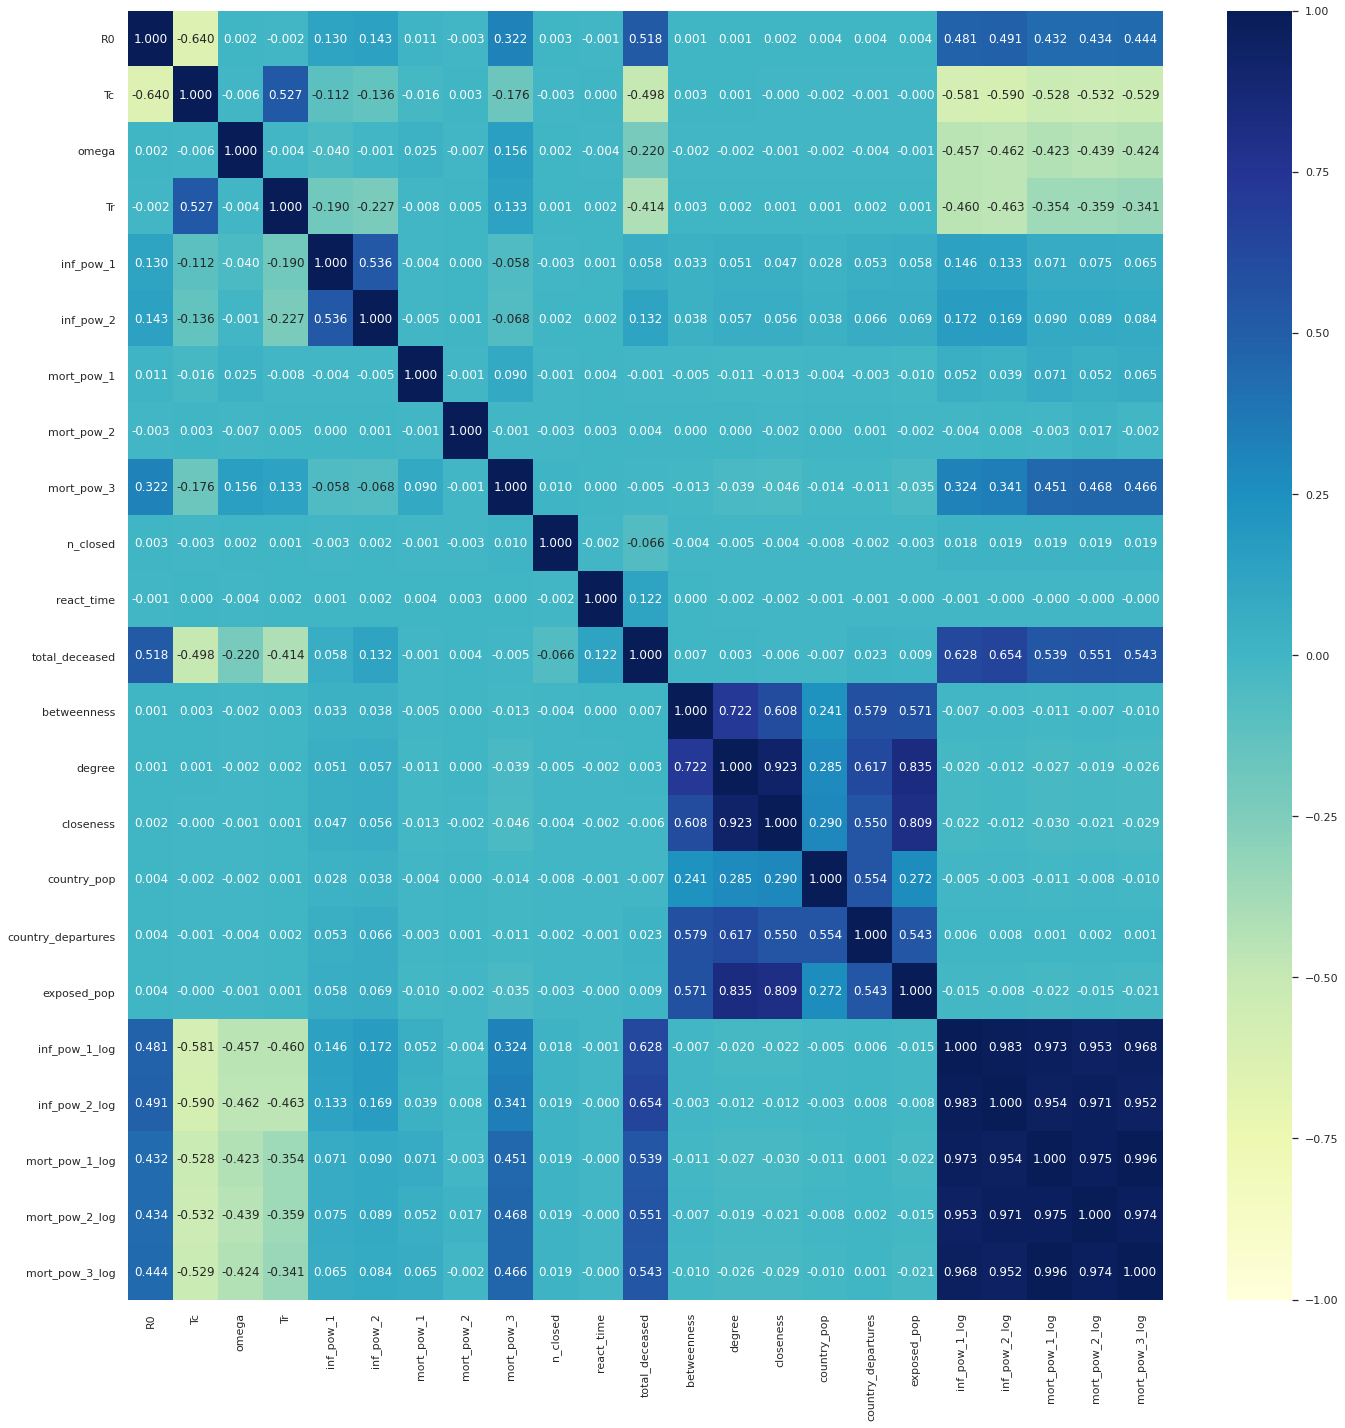

In [36]:
df = df_i.sample(200000, random_state=42)
df.reset_index(inplace=True)
df


features = [
    'R0',
    'Tc',
    'omega',
    'Tr',
    'inf_pow_1',
    'inf_pow_2',
    'mort_pow_1',
    'mort_pow_2',
    'mort_pow_3',
    'n_closed',
    'react_time',
    'total_deceased',
    'betweenness',
    'degree',
    'closeness',
    'country_pop',
    'country_departures',
    'exposed_pop',
    'inf_pow_1_log',
    'inf_pow_2_log',
    'mort_pow_1_log',
    'mort_pow_2_log',
    'mort_pow_3_log',
    ]

df= df[features]
corr_matrix = df.corr()
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.heatmap(corr_matrix, vmax=1, vmin=-1, annot=True, cmap="YlGnBu", ax=ax, fmt='.3f')
plt.tight_layout()

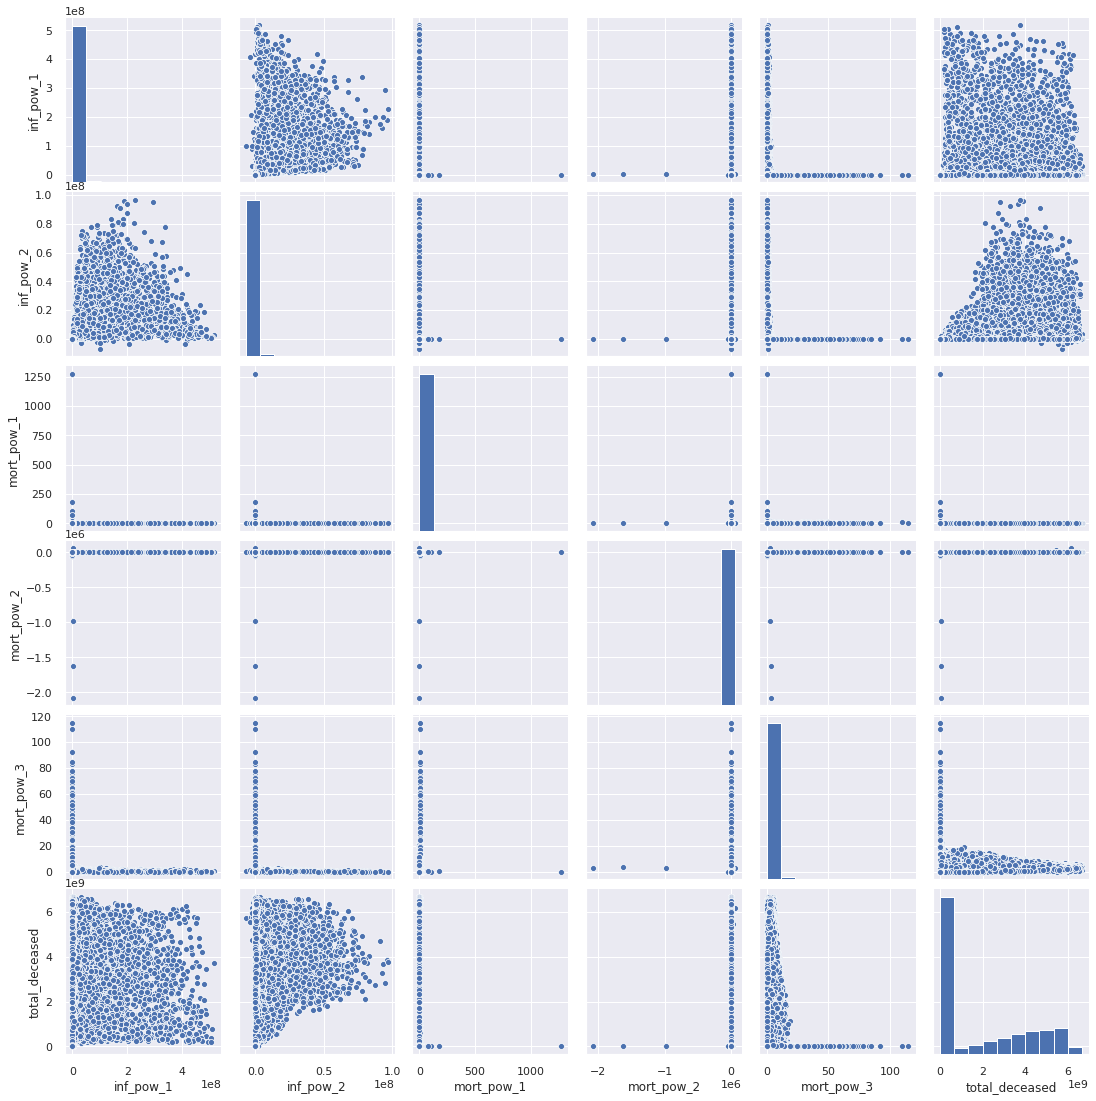

In [14]:
df = df_i.sample(200000, random_state=42)
df.reset_index(inplace=True)


features = [
    'inf_pow_1',
    'inf_pow_2',
    'mort_pow_1',
    'mort_pow_2',
    'mort_pow_3',
    'total_deceased',
    ]

df = df[features]

sns.pairplot(df)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(df[c], density=True, histtype='stepfilled', alpha=0.2)
ax.set(title=str(c))
plt.tight_layout()b

<AxesSubplot:xlabel='inf_pow_1', ylabel='total_deceased'>

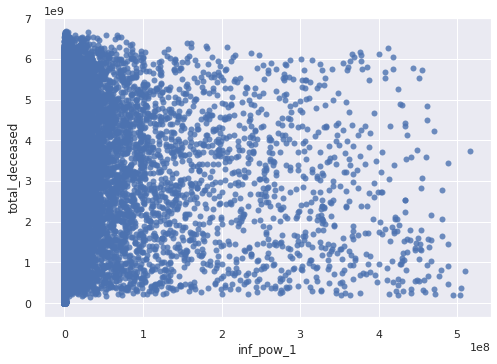

In [15]:
sns.regplot(x=df["inf_pow_1"], y=df["total_deceased"], fit_reg=False)

/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='inf_pow_1', ylabel='total_deceased'>

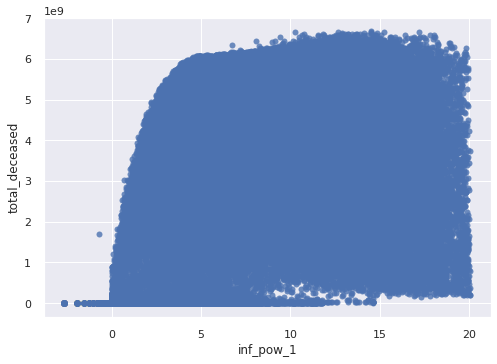

In [16]:
sns.regplot(x=np.log(df["inf_pow_1"]), y=df["total_deceased"], fit_reg=False)